In this [experiment](G_Transfer_Learning_with_MobileNet.ipynb), I used a pre-trained convolutional neural network to classify images of alpaca/not alpaca, with the starting code, hints, dataset and utility functions from the [Convolutional Neural Networks](https://coursera.org/learn/convolutional-neural-networks) course (offered by DeepLearning.AI on Coursera).

There are two parts. In the first part, I only trained the new classification layer. I imported a pre-trained MobileNet model, without the top layer (the classification layer), then add a new classifier layer. Only the newly-created classification layer will be trained on the alpaca image dataset, while the base MobileNet model is frozen.

In the second part, I fine-tuned the model by unfreezing the last several layers of the neural network, and re-train these final layers with low learning rate.

The result shows that validation accuracy and loss continues to improve when we allow the last layers of MobileNet to be trained on our specific alpaca classification task:
![plot_validation_loss_after_finetuning.png](plot_validation_loss_after_finetuning.png)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras.api._v2.keras as keras
import keras.layers as tfl
from keras.preprocessing import image_dataset_from_directory
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
# %cd /content/drive/Othercomputers/My Laptop/T_Repo/C4_W2_Assignment2/Files/W2A2
# %ls

In [25]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory, shuffle=True,
                                             batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                             validation_split=0.2, subset="training", seed=42)
validation_dataset = image_dataset_from_directory(directory, shuffle=True,
                                                  batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                                  validation_split=0.2, subset="validation", seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


<class 'tensorflow.python.framework.ops.EagerTensor'> (160, 160, 3)


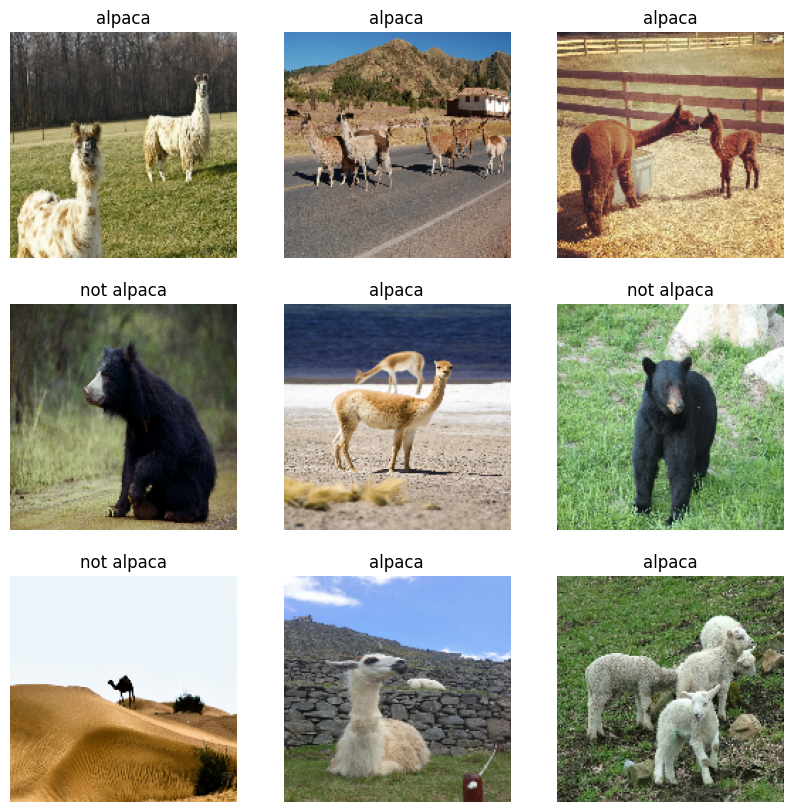

In [26]:
class_names = train_dataset.class_names
class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    print(type(images[0]), images[0].shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Preprocessing and Augmenting Training Data

In [27]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [28]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    aug = keras.Sequential()
    aug.add(keras.layers.RandomFlip("horizontal"))
    aug.add(keras.layers.RandomRotation(factor=0.2))
    return aug
    ### END CODE HERE

    return data_augmentation

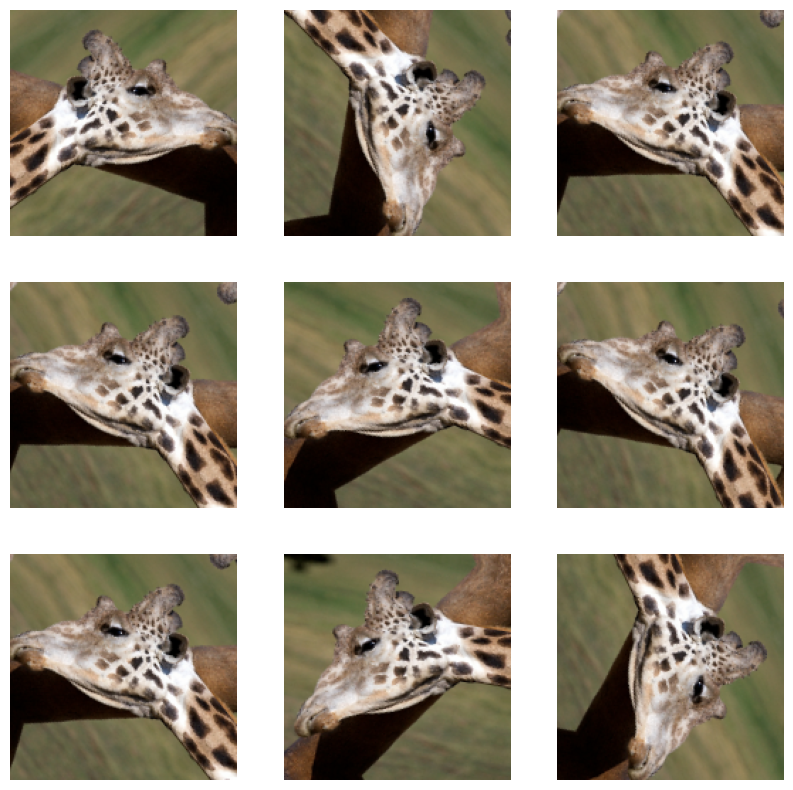

In [29]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [30]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

# Transfer Learning with MobileNet

## Part 1: Only training the classification layer

In [31]:
# Instantiate a pre-trained MobileNet model, without the top layer (the classification layer), then add a new classifier layer. Only the newly-created classification layer will be trained, while the base MobileNet model is frozen.

def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    ### START CODE HERE
    base_model = keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # freeze the base model by making it non trainable
    base_model.trainable = False
    # create the input layer (Same as the imageNetv2 input size)
    inputs = keras.Input(shape=input_shape)
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = keras.layers.GlobalAvgPool2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = keras.layers.Dropout(0.2)(x)
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = keras.layers.Dense(units=1, activation="linear")(x)

    model = keras.Model(inputs, outputs)

    return model

In [32]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [33]:
base_learning_rate = 0.001
model2.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
               loss=keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [34]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 5s 154ms/step - loss: 0.9161 - accuracy: 0.4733 - val_loss: 0.6015 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 1s 49ms/step - loss: 0.6461 - accuracy: 0.6031 - val_loss: 0.4983 - val_accuracy: 0.6769
Epoch 3/5
9/9 [==============================] - 1s 50ms/step - loss: 0.5503 - accuracy: 0.6641 - val_loss: 0.3972 - val_accuracy: 0.7538
Epoch 4/5
9/9 [==============================] - 1s 52ms/step - loss: 0.4995 - accuracy: 0.7214 - val_loss: 0.3623 - val_accuracy: 0.7846
Epoch 5/5
9/9 [==============================] - 1s 52ms/step - loss: 0.4249 - accuracy: 0.7710 - val_loss: 0.3442 - val_accuracy: 0.8000


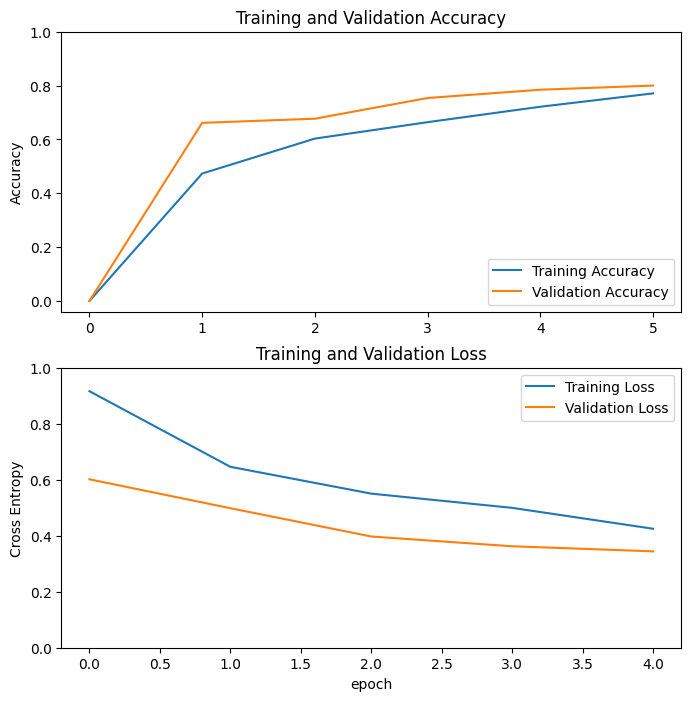

In [35]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()


## Part 2: Fine-tuning some layers from original model

In [36]:
# Fine tune the model by unfreezing the last several layers of the neural network, and re-train these final layers with low learning rate

In [37]:
model2.layers

In [38]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 154


In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1)
# Use accuracy as evaluation metric
metrics = ['accuracy']

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

In [40]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 160ms/step - loss: 0.3937 - accuracy: 0.7901 - val_loss: 0.4950 - val_accuracy: 0.7846
Epoch 6/10
9/9 [==============================] - 1s 55ms/step - loss: 0.3814 - accuracy: 0.8130 - val_loss: 0.2435 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 1s 55ms/step - loss: 0.2926 - accuracy: 0.8435 - val_loss: 0.1469 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 1s 57ms/step - loss: 0.2023 - accuracy: 0.9046 - val_loss: 0.1268 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 1s 57ms/step - loss: 0.1387 - accuracy: 0.9580 - val_loss: 0.1219 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 1s 58ms/step - loss: 0.0906 - accuracy: 0.9733 - val_loss: 0.1286 - val_accuracy: 0.9692


In [41]:
acc = acc + history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

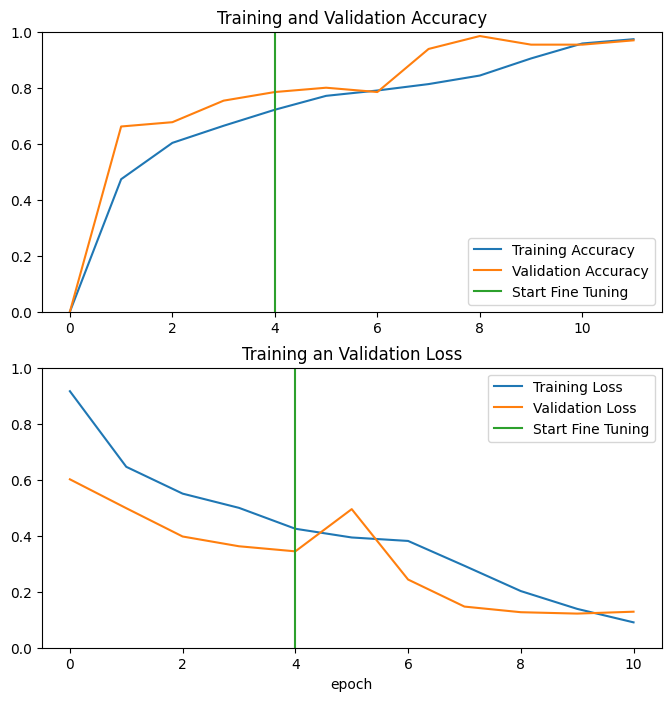

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training an Validation Loss")
plt.xlabel("epoch")
plt.show()